In [1]:
import pickle
import numpy as np
import pandas as pd
import multiprocessing
import my_functions as my
import matplotlib.pyplot as plt

from scipy import stats
from tqdm import tqdm, trange

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

In [2]:
# Importing the data
data = np.loadtxt('zipcombo.dat')

y = data[:, 0]
X = data[:, 1:]

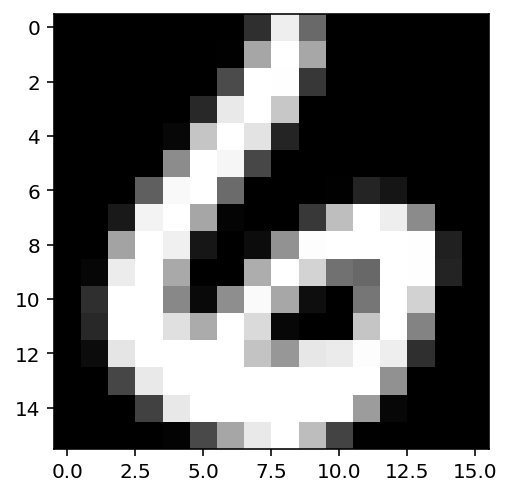

In [3]:
plt.imshow(X[0].reshape(16,16), cmap = 'gray');

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


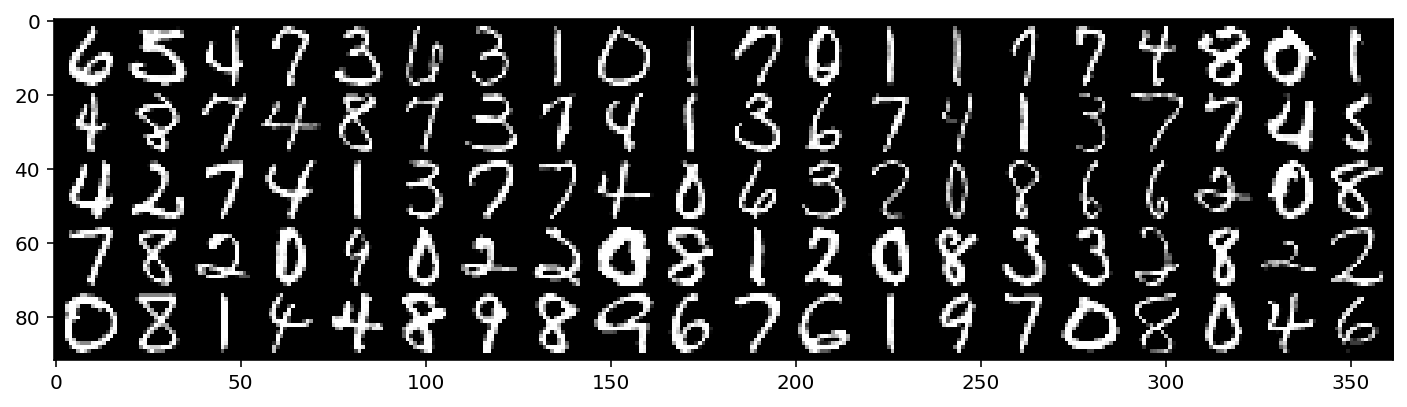

In [4]:
# Visualising a sample of the data
# Importing torch utilities just for plotting
import torch

from torchvision.utils import make_grid

plotting = torch.Tensor(X.reshape(-1,1,16,16))
plt.figure(figsize = (12,4))
plt.imshow(make_grid(plotting[:100], nrow = 20).permute(1,2,0));

# Data preparation for 1v1

In [5]:
def poly_kernel_matrix(X1, X2, d):
    """Fast computation of the polynomial kernel matrix for a given dataset."""
    gram = X1 @ X2.T
    return gram ** d

In [7]:
def encode_y(y, which_class):
    """Produces a one_hot encoding of the given vector of labels.
    
    Args:
    y (ndarray): vector of labels to encode
    classes (int): number of classes to encode represented in y. Default is 10 for our case.
    
    Returns:
    Y_one_hot (ndarray): matrix of shape (len(y), classes) of one hot encoded y
    """
    
    # Initialise matrix of negative ones
    Y_encoded = - np.ones((len(y)))
    
    # Fancy indexing to get "one hot". Assigning 1 to element at position y in every row
    Y_encoded[y == which_class] = 1
    
    return Y_encoded


In [8]:
def train_test_split(data, test_size = .33, random_state = 420):
	"""Utility function to split a dataset into train and test folds.
	
	Args:
        X (ndarray): Array of unlabeled data
        y (ndarray): Array of labels for X
        test_size (float): Float between 0 and 1. Determines the size of the test set
        random_state(int): Random state, for reproducibility, or generating different splits
	
	Returns:
        train_data, test_data(ndarrrays): Arrays of train/test split data
	"""

	np.random.seed(random_state)
	np.random.shuffle(data)
	test_data = data[:int(data.shape[0] * test_size), :]
	train_data = data[int(data.shape[0] * test_size):, :]

	return train_data, test_data

In [19]:
def split_dataset(data, classes = 10):
    """Prepares data for the 1v1 implementation of the multi-class kernel perceptron,
    by splitting the dataset into the different labels data"""
    sorted_data = data[np.argsort(data[:, 0], )]
    n_datasets = {}
    for n in range(classes):
        indexer = n == data[:, 0]
        n_datasets[n] = data[indexer, :]
    return n_datasets

def make_multiple_datasets(n_datasets, classes = 10, random_seed = 420):
    """Prepares the multiple datasets used in 1v1 multiclass"""
    np.random.seed(random_seed)
    datasets = {}
    for i in range(classes -1):
        for j in range(i +1, classes):
            this_dataset = np.vstack((n_datasets[i], n_datasets[j]))
            this_dataset = np.random.permutation(this_dataset)
            datasets[(i,j)] = this_dataset
    return datasets

# Training routine for 1v1

In [11]:
def train_test_perceptron_1v1(data, d, epochs = 5, random_seed = 420):

    """Train the multi-class kernel perceptron in 1v1 mode"""
    
    train_data, test_data = train_test_split(data, test_size = .2, random_state = random_seed)
    
    train_45 = make_multiple_datasets(split_dataset(train_data))
    alphas = []
    number_predictions_train = []
    number_predictions_test = []

    for keys, train_set in tqdm(train_45.items(), desc='Dataset n', leave = False):
        # Prepare Xs and ys
        X_train = train_set[:,1:]
        K_train = poly_kernel_matrix(X_train, X_train, d)
        
        y_train = train_set[:, 0]
        y_train = encode_y(y_train, keys[0])
        
        # Matrix of alpha which each row represent each of the 10 classes, change column value after each iteration   
        y_train = np.tile(y_train.T, epochs).T
        
        A = np.tile(K_train.T,epochs).T
        K_train =np.tile(A, epochs)
        
        alpha = np.zeros((1,len(K_train))) #  Initialise alphas to zeros

        for t in range(len(K_train)):

            WX = alpha[:,:t] @ K_train[:t,t].reshape(-1,1) # this is the summation term 

            if y_train[t] * np.squeeze(WX) <= 0:
                alpha[:,t] = y_train[t]
                
        alphas.append(np.squeeze(alpha))
        
        
        # Batch predict this training, record predicted number
        K_train_accuracy = poly_kernel_matrix(X_train, train_data[:, 1:], d) # train_data includes the ys so need to index
        K_train_accuracy = np.tile(K_train_accuracy.T, epochs).T
        WX_train = (alpha @ K_train_accuracy).T
        y_pred_train = np.squeeze(np.sign(WX_train))
        
        number_pred_train = np.copy(y_pred_train)
        number_pred_train[y_pred_train == -1] = keys[1]
        number_pred_train[y_pred_train == 1] = keys[0]
        
        number_predictions_train.append(number_pred_train)

        # Do the same for TEST data: batch predict, get predicted number
        K_test_accuracy = poly_kernel_matrix(X_train, test_data[:, 1:], d) # train_data includes the ys so need to index
        K_test_accuracy = np.tile(K_test_accuracy.T, epochs).T
        WX_train = (alpha @ K_test_accuracy).T
        y_pred_test = np.squeeze(np.sign(WX_train))
        
        number_pred_test = np.copy(y_pred_test)
        number_pred_test[y_pred_test == -1] = keys[1]
        number_pred_test[y_pred_test == 1] = keys[0]
        
        number_predictions_test.append(number_pred_test)
        
    
    # Get number predictions for train data
    number_predictions_train = np.stack(number_predictions_train, axis = 0)
    final_predictions_train = stats.mode(number_predictions_train, axis = 0)[0]
    # Get train y and calculate train accuracy
    train_y = train_data[:, 0]
    mistakes = (np.squeeze(final_predictions_train) != np.squeeze(train_y)).sum()
    train_accuracy = (train_data.shape[0] - mistakes) / train_data.shape[0]
    
    
    # Same for test now
    number_predictions_test = np.stack(number_predictions_test, axis = 0)
    final_predictions_test = stats.mode(number_predictions_test, axis = 0)[0]
    # Get train y and calculate train accuracy
    test_y = test_data[:, 0]
    mistakes = (np.squeeze(final_predictions_test) != np.squeeze(test_y)).sum()
    test_accuracy = (test_data.shape[0] - mistakes) / test_data.shape[0]


    return alphas, train_accuracy, test_accuracy

In [12]:
alphas, train_accuracy, test_accuracy = train_test_perceptron_1v1(data, 5, 5)
train_accuracy, test_accuracy

(0.9891114397096384, 0.9462076385153309)

# Protocol 1

In [13]:
# Comment on how many epochs you chose to use
def multi_run_polynomial(data, epochs = 5, degrees = None, runs = 20):
    """Runs the kernel perceptron multiple times with different polynomial orders and train-test splits.
    In this notebook, we run in 1v1 mode."""
    
    # Initialise polynomial degrees if not given
    if degrees is None:
        degrees = list(range(1, 8))
    
    train_accuracies = np.zeros((len(degrees), runs))
    test_accuracies = np.zeros((len(degrees), runs))
    
    for run in tqdm(range(runs), desc = 'Run'):
        # Set a seed for this run
        seed = np.random.seed(np.random.randint(0, 100))
        for degree in tqdm(degrees, desc = 'Degree', leave = False):
            _, train_accuracy, test_accuracy = train_test_perceptron_1v1(data, degree, epochs, random_seed = seed)
            train_accuracies[degree - 1, run] = train_accuracy
            test_accuracies[degree - 1, run] = test_accuracy
    return train_accuracies, test_accuracies

In [14]:
train_accuracies, test_accuracies = multi_run_polynomial(data, epochs = 5)
my.save_obj(train_accuracies, 'train_accuracies_poly_1v1')
my.save_obj(test_accuracies, 'test_accuracies_poly_1v1')

Run:   0%|          | 0/20 [00:00<?, ?it/s]








































































































































































































































































































































Run:   5%|▌         | 1/20 [07:48<2:28:19, 468.38s/it]








































































































































































































































































































































Run:  10%|█         | 2/20 [15:27<2:18:51, 462.85s/it]
































































































































































































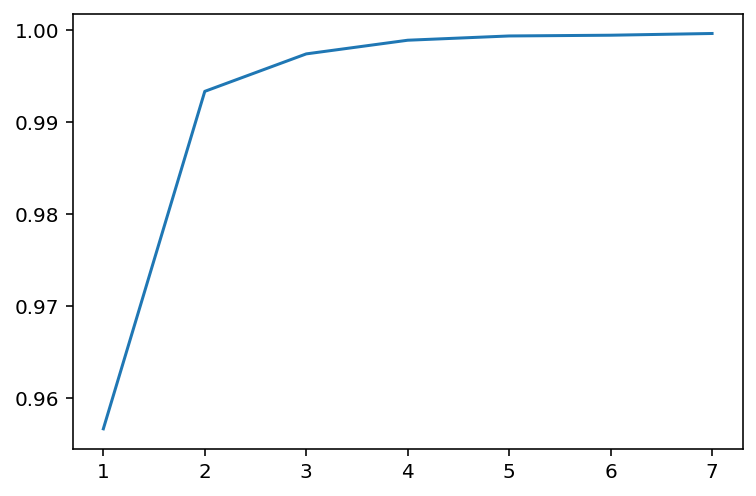

In [15]:
plt.plot(np.arange(1,8), train_accuracies.mean(axis = 1));

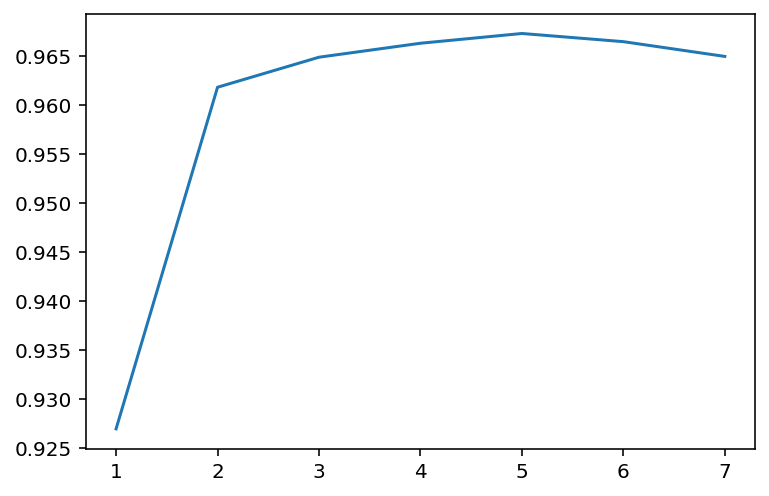

In [16]:
plt.plot(np.arange(1,8), test_accuracies.mean(axis = 1));

# Protocol 2

In [48]:
def train_validate_perceptron_1v1_indexed(train_dat, d, train_indices, val_indices, epochs = 5, random_seed = 420):

    """Train the multi-class kernel perceptron in 1v1 mode"""

    train_data = train_dat[train_indices,:]
    validation_data = train_dat[val_indices,:]
    
    
    train_45 = make_multiple_datasets(split_dataset(train_data), random_seed = random_seed)
    alphas = []
    number_predictions_train = []
    number_predictions_test = []

    for keys, train_set in train_45.items():
        # Prepare Xs and ys
        X_train = train_set[:,1:]
        K_train = poly_kernel_matrix(X_train, X_train, d)
        
        y_train = train_set[:, 0]
        y_train = encode_y(y_train, keys[0])
        
        # Matrix of alpha which each row represent each of the 10 classes, change column value after each iteration   
        y_train = np.tile(y_train.T, epochs).T
        
        A = np.tile(K_train.T,epochs).T
        K_train =np.tile(A, epochs)
        
        alpha = np.zeros((1,len(K_train))) #  Initialise alphas to zeros

        for t in range(len(K_train)):

            WX = alpha[:,:t] @ K_train[:t,t].reshape(-1,1) # this is the summation term 

            if y_train[t] * np.squeeze(WX) <= 0:
                alpha[:,t] = y_train[t]
                
        alphas.append(np.squeeze(alpha))
        
        
        # Batch predict this training, record predicted number
        K_train_accuracy = poly_kernel_matrix(X_train, train_data[:, 1:], d) # train_data includes the ys so need to index
        K_train_accuracy = np.tile(K_train_accuracy.T, epochs).T
        WX_train = (alpha @ K_train_accuracy).T
        y_pred_train = np.squeeze(np.sign(WX_train))
        
        number_pred_train = np.copy(y_pred_train)
        number_pred_train[y_pred_train == -1] = keys[1]
        number_pred_train[y_pred_train == 1] = keys[0]
        
        number_predictions_train.append(number_pred_train)

        # Do the same for TEST data: batch predict, get predicted number
        K_test_accuracy = poly_kernel_matrix(X_train, validation_data[:, 1:], d) # train_data includes the ys so need to index
        K_test_accuracy = np.tile(K_test_accuracy.T, epochs).T
        WX_train = (alpha @ K_test_accuracy).T
        y_pred_test = np.squeeze(np.sign(WX_train))
        
        number_pred_test = np.copy(y_pred_test)
        number_pred_test[y_pred_test == -1] = keys[1]
        number_pred_test[y_pred_test == 1] = keys[0]
        
        number_predictions_test.append(number_pred_test)
        
    
    # Get number predictions for train data
    number_predictions_train = np.stack(number_predictions_train, axis = 0)
    final_predictions_train = stats.mode(number_predictions_train, axis = 0)[0]
    # Get train y and calculate train accuracy
    train_y = train_data[:, 0]
    mistakes = (np.squeeze(final_predictions_train) != np.squeeze(train_y)).sum()
    train_accuracy = (train_data.shape[0] - mistakes) / train_data.shape[0]
    
    
    # Same for test now
    number_predictions_test = np.stack(number_predictions_test, axis = 0)
    final_predictions_test = stats.mode(number_predictions_test, axis = 0)[0]
    # Get train y and calculate train accuracy
    test_y = validation_data[:, 0]
    mistakes = (np.squeeze(final_predictions_test) != np.squeeze(test_y)).sum()
    test_accuracy = (validation_data.shape[0] - mistakes) / validation_data.shape[0]


    return alphas, train_accuracy, test_accuracy

In [49]:
def cross_validate_1v1(data, n_splits = 5, cross_epochs = 4, epochs = 5, degrees = None, runs = 20):
    """Runs the kernel perceptron multiple times with different polynomial orders and train-test splits.
    Cross-validates to find the best polynomial order.
    In this notebook, we run in 1v1 mode."""
    
    # Initialise polynomial degrees if not given
    if degrees is None:
        degrees = list(range(1, 8))
    
    train_accuracies = np.zeros((len(degrees), runs, n_splits))
    val_accuracies = np.zeros((len(degrees), runs, n_splits))
    best_degrees = np.zeros((runs))
    test_accuracies = np.zeros((runs))
    
    for run in tqdm(range(runs), desc = 'Run'):
        # Set a seed for this run
        seed = np.random.seed(np.random.randint(0, 100))
        train_data, _ = train_test_split(data, test_size = .2, random_state = seed)
        for i_split, (train_indices, val_indices) in enumerate(my.cross_validation_split(train_data, n_splits)):
            for degree in degrees:
                _, train_accuracy, validation_accuracy = train_validate_perceptron_1v1_indexed(train_data, degree, train_indices, val_indices,  cross_epochs, random_seed = seed)
                train_accuracies[degree-1, run, i_split] = train_accuracy
                val_accuracies[degree-1, run, i_split] = validation_accuracy
                
        # Get the best polynomial degree for this run of cross validation
        best_degree = np.argmax(np.mean(val_accuracies[:, run, :], axis = 1)) + 1 # To counter python indexing
        best_degrees[run] = int(best_degree)
        
        # Retrain on the test set using best degree
        _, _, test_accuracy = train_test_perceptron_1v1(data, best_degree, 5, random_seed = seed)
        test_accuracies[run] = test_accuracy
        
    return train_accuracies, val_accuracies, test_accuracies, best_degrees

In [55]:
train_accuracies, val_accuracies,  test_accuracies, best_degrees = cross_validate_1v1(data, n_splits = 5, cross_epochs = 3,  epochs = 4, degrees = None, runs = 20)

np.save('train_accuracies_cross_1v1', train_accuracies)
np.save('val_accuracies_cross_1v1', val_accuracies)
np.save('best_degrees_1v1', best_degrees)
np.save('test_accuracies_cross_1v1', test_accuracies)

Run: 100%|██████████| 20/20 [5:06:51<00:00, 920.59s/it]  
